# Best location to open a gym in Toronto

## Table of Contents

* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Exploratory Data Analysis](#Exploratory_Data_Analysis)
* [Results and Discussion](#Results_and_Discussion)
* [Conclusion](#Conclusion)




# 1. Introduction <a class="anchor" id="Introduction"></a>

### 1.1 Background

People in these day and age incorporate fitness into their lifestyle. thus, we can see the surge of gyms and fitness that answer to these demands. but opening a gym or other business is a tough decision, it involves making many difficult decisions such as: Who is our targeted customers, How much should be cost for the gym membership cost? Are there any competitions in the region? And one of the most important question that needs thorough answer would be what is the best location for customers to come and excercise and in turn will optimize the profitability.

### 1.2 Business Problem

Imagine a client that want to open a gym in Toronto and want our service to help find the optimum location that will benefit the business in the long run. which location in Toronto is the optimum point of interest? we first need to think about the factors that contribute to this. it would be based on income, competition and desity of people in the neighborhood can also play an important factor as well. so, to solve these problem, we will mainly use Foursquare API to get the venues location, Neighborhoods in Toronto from Wikipedia and census data from Toronto’s Open Data Portal.

### 1.3 Interest 

The targeted audiences of this project would be the business people who want to open a new gym or expand their franchised. through this study, they will have a clear overview of the locations in Toronto and can confidently target their specific clients, which will give them competitive advantage and a head start in the gym business.

# 2. Data <a class="anchor" id="Data"></a>

### 2.1 Data Sources

We mainly focus on 4 data sources in this instance.
1. <a href='https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'>Wikipedia</a>: We will extract the postal code, borough and neighborhoods in Toronto.
2. <a href='https://cocl.us/Geospatial_data'>Geospatial Data</a>: A geospatial data of Toronto that contains the Postal code along with latitude and longitude of neighborhoods in Toronto.
3. Foursquare API: An API call to get the locations and information of venues in toronto. (Foursquare API requires a developer account in order to log in) 
4. <a href='http://map.toronto.ca/wellbeing/#eyJ0b3Itd2lkZ2V0LWNsYXNzYnJlYWsiOsSAcGVyY2VudE9wYWNpdHnElzcwfSwiY3VzxIJtYcSTYcSXxIBuZWlnaGJvdXJob29kc8S2fcSrxIHEg8SFxIfEicSLdGFixYXEmCLEo3RpdmVUxZBJZMSXxYnEhMWPYi1pbmRpY2HEgnLFhcWIYWdzTWFwxLYiesWCbcSXMTPErHjEly04ODM3NzQ2LjDEqTc4MDnErMSnOjU0MTI5MzkuOTIyxorGmsWIxaTFpsWoxarFksSAxZjFq2lvbsSXMsSsc8WkZ2xlxYbErMWWbWVzxJtpxrbGssStxL%2FEk8SfScWlxafFqcSDTcWDxrE6IsatbsavxrHFhw%3D%3D'>Toronto Census data</a>: List of total population, household income and other info in the neighborhoods in toronto. 

### 2.2 Data Cleaning

Below procedures are summary the data cleaning and wrangling process:
1. Pulling data from data sources.
2. Drop row and column based on data quality.
3. Mapping all data into one table.
4. Prepare data by selecting and applying standard scaling to the features that will be used in the K-mean clustering model.

#### install important packages

In [1]:
#Uncomment below if packages haven't installed
!pip install beautifulsoup4
!pip install requests
!pip install geocoder
!pip install folium

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: 

### *Note: If the maps in folium library don't render properly, please copy the notebook link or file and view it in https://nbviewer.jupyter.org/*

#### Import neccessary libraries

In [2]:
from bs4 import BeautifulSoup # library for Web scraping
import requests # library for GET request
import pandas as pd # library for data analsysis
import folium # map rendering library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np # library to handle data in a vectorized manner

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#### Extract Toronto neighborhoods along with Postal Code from Wikipedia

In [3]:
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050"
html_doc = requests.get(url).text
soup = BeautifulSoup(html_doc, 'html.parser')

table_contents=[]
table=soup.find('table')

for row in table.findAll('tr'):
    cell = {}
    arr = []    
    for td in row.findAll('td'):
        arr.append(td.text.replace('\n', ''))
    
    if len(arr) == 3:
        cell['PostalCode'] = arr[0]
        cell['Borough'] = arr[1]
        cell['Neighborhood'] = arr[2]
        table_contents.append(cell)

df = pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Stn A PO Boxes 25 The Esplanade':'Downtown Toronto Stn A',
                                             'Business Reply Mail Processing Centre 969 Eastern':'East Toronto Business'})

df = df[~((df.Borough == 'Not assigned') & (df.Neighborhood == 'Not assigned'))]
df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


#### Download Geospatial data that contains latitude and longitude of neighborhoods in Toronto

In [4]:
!wget -q -O 'geospatial.csv' https://cocl.us/Geospatial_data
sp_df = pd.read_csv('geospatial.csv')
sp_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merge Toronto neighborhood with Geospatial data

In [5]:
df_neighborhood = df.join(sp_df.set_index('Postal Code'), on='PostalCode')
df_neighborhood.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M6A,North York,Lawrence Heights,43.718518,-79.464763
6,M6A,North York,Lawrence Manor,43.718518,-79.464763


#### Read Toronto cesus data file within the project

In [6]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,Neighbourhood Id,Combined Indicators,Total Population,Average Family Income,After-Tax Household Income,Pop 15 - 64 years
0,West Humber-Clairville,1.0,NaN,33312.0,72820.0,59703.0,23285.0
1,Mount Olive-Silverstone-Jamestown,2.0,NaN,32954.0,57411.0,46986.0,22300.0
2,Thistletown-Beaumond Heights,3.0,NaN,10360.0,70838.0,57522.0,6760.0
3,Rexdale-Kipling,4.0,NaN,10529.0,69367.0,51194.0,7165.0
4,Elms-Old Rexdale,5.0,NaN,9456.0,61196.0,49425.0,6370.0


#### Merge all relevant tables into single table

<dl>
    <dt>Note:</dt>
    <dd>* <i>Drop NaN row in Total Population column</i></dd> 
    <dd>* <i>We join table together using neighborhood name as primary key, because of census data doesn't have postal code</i></dd>
</dl>

In [7]:
df_merge = df_neighborhood.join(df_data_1[['Neighbourhood', 'Total Population', 'Average Family Income']].set_index('Neighbourhood'), on='Neighborhood')
df_merge = df_merge[~df_merge['Total Population'].isnull()]
df_merge.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total Population,Average Family Income
3,M4A,North York,Victoria Village,43.725882,-79.315572,17510.0,65104.0
10,M1B,Scarborough,Rouge,43.806686,-79.194353,46496.0,86997.0
11,M1B,Scarborough,Malvern,43.806686,-79.194353,43794.0,64497.0
26,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494.0,98857.0
30,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933.0,55824.0


#### Now that we have the required toronto information, Let's see how many gyms are in each neighborhoods using Foursquare API

#### Define Foursquare Credentials and Version


In [8]:
# The code was removed by Watson Studio for sharing.

#### Define getAllVenues to loop through all neighborhoods and find gym venues within 2500m radius

In [9]:
def getAllVenues(names, latitudes, longitudes):
    
    venues_list=[]
    query = 'gym'
    radius = 2000
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print("Searching for: ", name)    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng,
        query,
        radius
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
#        print(json_normalize(results))
        # return only relevant information for each nearby venue
        for v in results:
            
            try:
                vname = v['name']
                vlat = v['location']['lat']
                vlng = v['location']['lng']
                vcat = v['categories'][0]['name']
    
            except IndexError:
                vname = ''
                vlat = 0
                vlng = 0
                vcat = ''
                
#            print(name, lat, lng, vname, vlat, vlng, vcat)            
            venues_list.append([(name, lat, lng, vname, vlat, vlng, vcat)])

            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                 'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### We store all venues from Foursquare API in toronto_venues DataFrame

In [10]:
toronto_venues = getAllVenues(names=df_merge['Neighborhood'],
                                   latitudes=df_merge['Latitude'],
                                   longitudes=df_merge['Longitude']
                                  )
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Gym,43.725821,-79.309808,Residential Building (Apartment / Condo)
1,Victoria Village,43.725882,-79.315572,Concorde Park Condo Gym,43.730832,-79.327232,Gym
2,Victoria Village,43.725882,-79.315572,Clancy's Boxing Gym,43.718510,-79.308707,Gym / Fitness Center
3,Victoria Village,43.725882,-79.315572,Tridel Accolade Gym,43.724403,-79.327789,Gym / Fitness Center
4,Victoria Village,43.725882,-79.315572,Bell Wynford Gym,43.726770,-79.332272,Gym / Fitness Center


#### Let's have a basic info of venues data

In [11]:
toronto_venues.describe(include='all')

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,274,274.000000,274.000000,274,274.000000,274.000000,274
unique,34,NaN,NaN,166,NaN,NaN,25
top,Little Portugal,NaN,NaN,,NaN,NaN,Gym
freq,30,NaN,NaN,17,NaN,NaN,123
mean,NaN,43.704125,-79.387624,NaN,40.992282,-74.458077,NaN
std,NaN,0.058138,0.092672,NaN,10.562341,19.185289,NaN
min,NaN,43.602414,-79.577201,NaN,0.000000,-79.583809,NaN
25%,NaN,43.648960,-79.442259,NaN,43.642177,-79.426107,NaN
50%,NaN,43.696948,-79.411307,NaN,43.706161,-79.393845,NaN
75%,NaN,43.744734,-79.340923,NaN,43.733476,-79.317709,NaN


#### We group and count all venues from our search in Foursquare API

In [12]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhoods column back to dataframe !(instead of neighborhood as Venues category also has the name neighborhood)!
toronto_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhoods').sum().reset_index()
print('The group table has {} columns and {} rows.'.format(toronto_grouped.shape[1], toronto_grouped.shape[0]))
toronto_grouped.head(5)

The group table has 26 columns and 34 rows.


,Neighborhoods,,Athletics & Sports,Basketball Court,Boxing Gym,Building,College Gym,Dance Studio,General Entertainment,Gym,...,Park,Playground,Pool,Residential Building (Apartment / Condo),School,Spa,Sports Bar,Sports Club,Student Center,Yoga Studio
0,Agincourt North,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,Alderwood,0,1,0,0,0,2,0,0,3,...,0,0,0,0,0,1,0,0,0,0
2,Bathurst Manor,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,2,...,1,0,0,1,0,0,0,0,0,0
4,Cliffcrest,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### We combine gym related columns

In [13]:
toronto_grouped['No. of Gym Center'] = toronto_grouped['Gym'] + toronto_grouped['Gym / Fitness Center']
toronto_gym = toronto_grouped[['Neighborhoods', 'No. of Gym Center']]
toronto_gym.head()

,Neighborhoods,No. of Gym Center
0,Agincourt North,1
1,Alderwood,4
2,Bathurst Manor,3
3,Bayview Village,2
4,Cliffcrest,0


#### We successfully created  the final table for our study by mapping the number of Gyms table into the toronto data

In [14]:
toronto_data = df_merge.join(toronto_gym.set_index('Neighborhoods'), on='Neighborhood').reset_index(drop=True)
#toronto_data.dropna(subset = ['No. of Gym Center'], inplace=True)
toronto_data['No. of Gym Center'] = toronto_data['No. of Gym Center'].fillna(0)
toronto_data.reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total Population,Average Family Income,No. of Gym Center
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510.0,65104.0,11.0
1,M1B,Scarborough,Rouge,43.806686,-79.194353,46496.0,86997.0,2.0
2,M1B,Scarborough,Malvern,43.806686,-79.194353,43794.0,64497.0,2.0
3,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494.0,98857.0,2.0
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933.0,55824.0,13.0


# 3. Methodology <a class="anchor" id="Methodology"></a>

The above data will be combined together into a single table using pandas library and will further apply standard scaling operation to further help with our model that will be used in this study. the samples are roughly 40 samples and 3 to 4 features will be selected based on quality and its relation to the study.

- For wikipedia, the data will be scraped from table and loop through each row and table data using Beautifysoup library, which will give us the list of all neighborhoods along with its borough and postal code in Toronto. some row needs to be drop due to NA information in both borough and neighborhood columns.

- We also need geo spatial file, which contains the postal code, latitude and longitude of the neighborhoods, in order to visualize the toronto maps and help us better understand when we cluster the neighborhoods using k-mean clustering model.

- After combine the geospatial data with neighborhoods data using postal code as its primary key, we will use the Foursquare API to query the gym center in the area and count the gym centers in each neighborhood. thus, we add the number of gym center into our table and use it as a feature in the upcoming model.

- Two more features can be found in Toronto census data, which will list down all the neighborhoods along with option to specified the information that will want, in this case, it would be the total population and average household income in each neighborhoods.

- Overall, 3 features will be selected in this study. Total population, average household income and frequency of gym centers in the area.

- After the required information is gathered and put into a table, we then can select the features in the table for our k-mean clustering model.
    - Standard scaling technique will be used on the 3 features to scale down data into similar units to facilitate the model training.
    - The output of the training will be the cluster labels that will be used to map back into the toronto_data table, thus, we can used the labeled dataset to visualize in folium map.
    - Finally, we will discuss and conclude the result of the clustering. 



# 4. Exploratory Data Analysis <a class="anchor" id="Exploratory_Data_Analysis"></a>

### 4.1 Let's view Toronto's neighborhoods superimposed on top.

In [15]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

fig = folium.Figure(width=800, height=450)

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  


fig.add_child(map_toronto)
fig

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### 4.2 Distribution of Gyms in the neighborhoods

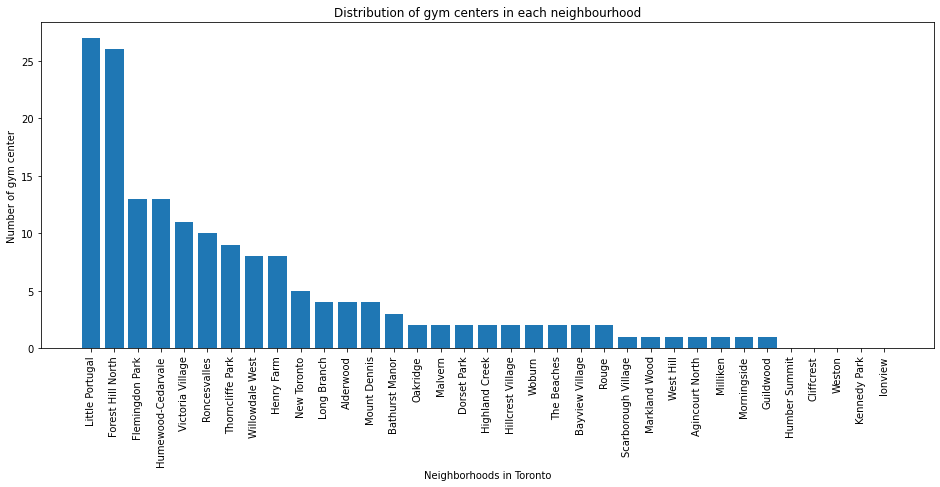

In [16]:
df_gym = pd.DataFrame(toronto_data[['Neighborhood', 'No. of Gym Center']])
df_gym.sort_values(by=['No. of Gym Center'], ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
ax.bar(df_gym['Neighborhood'], df_gym['No. of Gym Center'], align='center')
ax.set_ylabel('Number of gym center')
ax.set_xlabel('Neighborhoods in Toronto')
ax.set_title('Distribution of gym centers in each neighbourhood')
plt.xticks(rotation='vertical')
fig.show()

### 4.3 Distribution of population in the neighborhoods

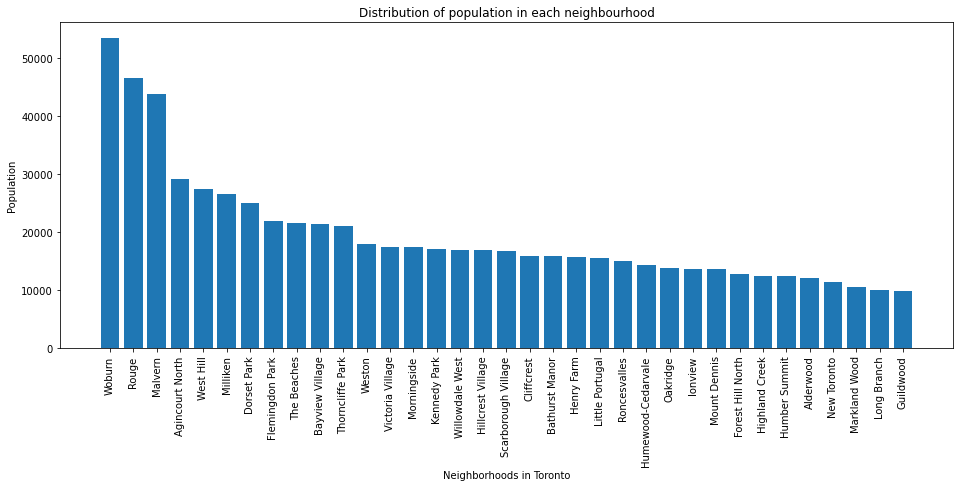

In [17]:
df_population = pd.DataFrame(toronto_data[['Neighborhood', 'Total Population']])
df_population.sort_values(by=['Total Population'], ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
ax.bar(df_population['Neighborhood'], df_population['Total Population'], align='center')
ax.set_ylabel('Population')
ax.set_xlabel('Neighborhoods in Toronto')
ax.set_title('Distribution of population in each neighbourhood')
plt.xticks(rotation='vertical')
fig.show()

### 4.4 Average household income in the neighborhoods

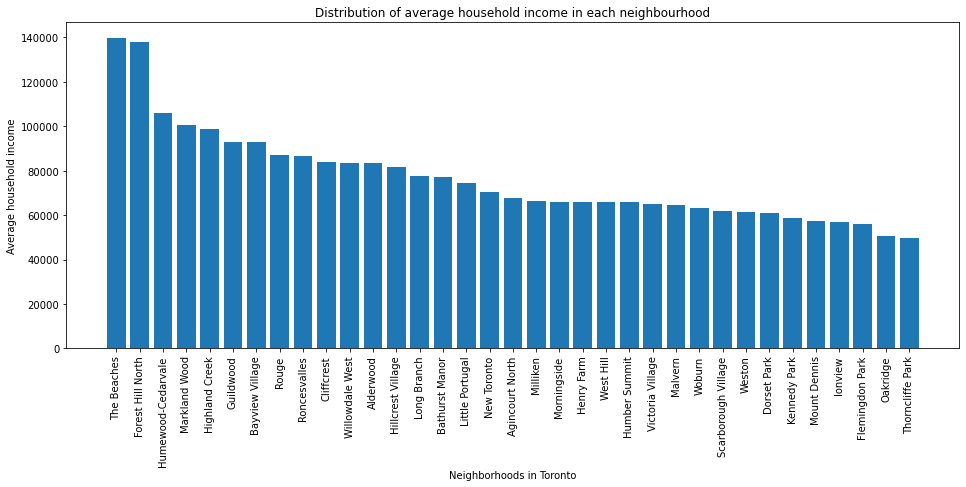

In [18]:
df_income = pd.DataFrame(toronto_data[['Neighborhood', 'Average Family Income']])
df_income.sort_values(by=['Average Family Income'], ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
ax.bar(df_income['Neighborhood'], df_income['Average Family Income'], align='center')
ax.set_ylabel('Average household income')
ax.set_xlabel('Neighborhoods in Toronto')
ax.set_title('Distribution of average household income in each neighbourhood')
plt.xticks(rotation='vertical')
fig.show()

### 4.5. Modeling selection

### 4.5.1 Data Preprocessing

<p>Features selection for K-mean modeling.</p>

In [19]:
k_mean_data = toronto_data.drop(['PostalCode','Borough', 'Neighborhood', 'Latitude', 'Longitude'], axis=1)
k_mean_data.head()

,Total Population,Average Family Income,No. of Gym Center
0,17510.0,65104.0,11.0
1,46496.0,86997.0,2.0
2,43794.0,64497.0,2.0
3,12494.0,98857.0,2.0
4,21933.0,55824.0,13.0


<p>Using standard scaling technique, we will be able to scale all the data to facilitate the modeling algorithm.</p>

In [20]:
from sklearn.preprocessing import StandardScaler

X = k_mean_data.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset[0:5]

array([[-0.20307124, -0.54406583,  0.94712737],
       [ 2.69944643,  0.5026181 , -0.44052436],
       [ 2.42888124, -0.57308594, -0.44052436],
       [-0.70534919,  1.06963365, -0.44052436],
       [ 0.23982656, -0.98773398,  1.25549443]])

### 4.5.2 k-Means Cluster Modeling

In [21]:
distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init="k-means++", n_clusters=k, n_init=12)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

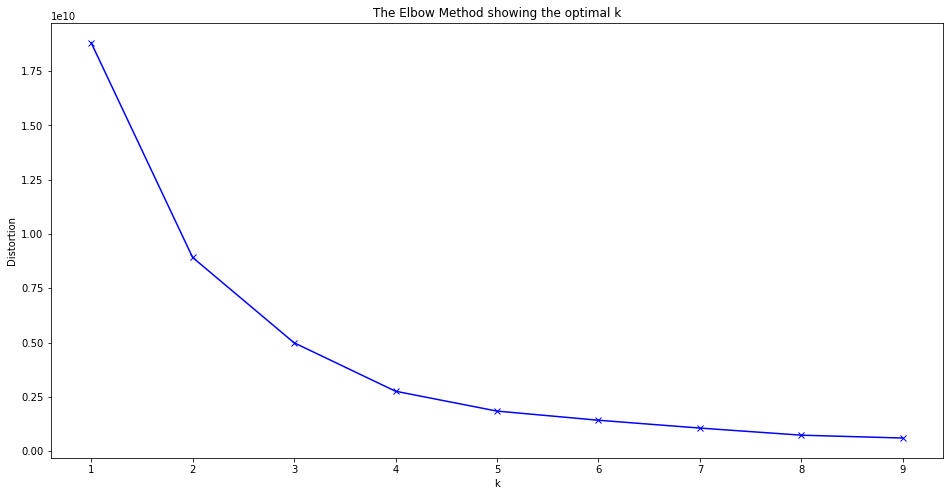

In [22]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [23]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[3 1 1 0 3 0 0 0 3 3 0 1 0 0 3 3 3 2 3 3 0 3 3 0 3 3 3 2 0 0 3 3 3 0 0]


### 4.5.3 Visualize labels after modeling

In [24]:
toronto_data.insert(0, 'Cluster Labels', labels)
toronto_data.head()

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total Population,Average Family Income,No. of Gym Center
0,3,M4A,North York,Victoria Village,43.725882,-79.315572,17510.0,65104.0,11.0
1,1,M1B,Scarborough,Rouge,43.806686,-79.194353,46496.0,86997.0,2.0
2,1,M1B,Scarborough,Malvern,43.806686,-79.194353,43794.0,64497.0,2.0
3,0,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494.0,98857.0,2.0
4,3,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933.0,55824.0,13.0


In [25]:
fig = folium.Figure(width=800, height=450)

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 0.8, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood'], toronto_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        alpha=1,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
fig.add_child(map_clusters)
fig

# 5. Results and Discussion <a class="anchor" id="Results_and_Discussion"></a>

### 5.1 Clusters overview

### Cluster 1

In [26]:
toronto_data.loc[toronto_data['Cluster Labels'] == 0, toronto_data.columns[1:len(toronto_data.columns)]]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total Population,Average Family Income,No. of Gym Center
3,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494.0,98857.0,2.0
5,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,14365.0,105770.0,13.0
6,M9C,Etobicoke,Markland Wood,43.643515,-79.577201,10554.0,100337.0,1.0
7,M1E,Scarborough,Guildwood,43.763573,-79.188711,9917.0,92858.0,1.0
10,M4E,East Toronto,The Beaches,43.676357,-79.293031,21567.0,139757.0,2.0
12,M2H,North York,Hillcrest Village,43.803762,-79.363452,16934.0,81484.0,2.0
13,M3H,North York,Bathurst Manor,43.754328,-79.442259,15873.0,76914.0,3.0
20,M2K,North York,Bayview Village,43.786947,-79.385975,21396.0,92800.0,2.0
23,M1M,Scarborough,Cliffcrest,43.716316,-79.239476,15935.0,83694.0,0.0
28,M2R,North York,Willowdale West,43.782736,-79.442259,16936.0,83632.0,8.0


#### Cluster 1 Explaination:
<p><b>- HIGH</b> TARGET CUSTOMERS</p></br>
<p><b>- MID</b> HOUSEHOLD INCOME</p></br>
<p><b>- LOW</b> COMPETITIONS</p></br>

### Cluster 2

In [27]:
toronto_data.loc[toronto_data['Cluster Labels'] == 1, toronto_data.columns[1:len(toronto_data.columns)]]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total Population,Average Family Income,No. of Gym Center
1,M1B,Scarborough,Rouge,43.806686,-79.194353,46496.0,86997.0,2.0
2,M1B,Scarborough,Malvern,43.806686,-79.194353,43794.0,64497.0,2.0
11,M1G,Scarborough,Woburn,43.770992,-79.216917,53485.0,63186.0,2.0


#### Cluster 2 Explaination:
<p><b>- LOW</b> TARGET CUSTOMERS</p></br>
<p><b>- MID</b> HOUSEHOLD INCOME</p></br>
<p><b>- LOW</b> COMPETITIONS</p></br>
    

### Cluster 3

In [28]:
toronto_data.loc[toronto_data['Cluster Labels'] == 2, toronto_data.columns[1:len(toronto_data.columns)]]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total Population,Average Family Income,No. of Gym Center
17,M6J,West Toronto,Little Portugal,43.647927,-79.419750,15559.0,74372.0,27.0
27,M5P,Central Toronto,Forest Hill North,43.696948,-79.411307,12806.0,137887.0,26.0


#### Cluster 3 Explaination:
<p><b>- LOW</b> TARGET CUSTOMERS</p></br>
<p><b>- HIGH</b> HOUSEHOLD INCOME</p></br>
<p><b>- HIGH</b> COMPETITIONS</p></br>
    

### Cluster 4

In [29]:
toronto_data.loc[toronto_data['Cluster Labels'] == 3, toronto_data.columns[1:len(toronto_data.columns)]]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Total Population,Average Family Income,No. of Gym Center
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510.0,65104.0,11.0
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933.0,55824.0,13.0
8,M1E,Scarborough,Morningside,43.763573,-79.188711,17455.0,66024.0,1.0
9,M1E,Scarborough,West Hill,43.763573,-79.188711,27392.0,65871.0,1.0
14,M4H,East York,Thorncliffe Park,43.705369,-79.349372,21108.0,49530.0,9.0
15,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,16724.0,61631.0,1.0
16,M2J,North York,Henry Farm,43.778517,-79.346556,15723.0,65901.0,8.0
18,M1K,Scarborough,Ionview,43.727929,-79.262029,13641.0,57069.0,0.0
19,M1K,Scarborough,Kennedy Park,43.727929,-79.262029,17123.0,58513.0,0.0
21,M1L,Scarborough,Oakridge,43.711112,-79.284577,13845.0,50793.0,2.0


#### Cluster 4 Explaination:
<p><b>- LOW</b> TARGET CUSTOMERS</p></br>
<p><b>- MID</b> HOUSEHOLD INCOME</p></br>
<p><b>- HIGH</b> COMPETITIONS</p></br>
    

In [30]:
toronto_data.groupby('Cluster Labels').mean()

,Latitude,Longitude,Total Population,Average Family Income,No. of Gym Center
Cluster Labels,,,,,
0,43.712280,-79.389565,14852.538462,92597.076923,4.000000
1,43.794788,-79.201875,47925.000000,71560.000000,2.000000
2,43.672437,-79.415528,14182.500000,106129.500000,26.500000
3,43.736610,-79.334229,18741.529412,61543.411765,3.470588


### 5.2 Summary Clusters

### In summary: 
<p><b>Cluster 1:</b> With high to mid population and spending power, with few competitors in the area signifies the lack of interest from population. But with good marketing campaign of healthy lifestyle, there could be a lot of potential customers in these neighborhoods.</p>
<p><b>Cluster 2:</b> Low population in the area could be the concern of return of investment. thus, investment in these neighborhoods wouldn't be a good choice.</p>
<p><b>Cluster 3:</b> High competitors and spending power shows that these neighborhoods are premium customers even if the population is relatively low, because of the spending power, 1 customers could be a member of multiple gym centers.</p>
<p><b>Cluster 4:</b> poses high barrier of entry with high competitors in the neighborhood and low population. thus, customers in these neighborhood would be cautious when choosing the gym of their choise.</p>

# 6. Conclusion: <a class="anchor" id="Conclusion"></a>

<p>Throughout this study, 4 cluster labels are chose based on K-mean elbow method. within these 4 labels, the most promising label would be in Cluster 1, as it has high population, mid spending power and less competitions give us opportunity to penetrate these neighborhoods. 
with more research and study into these neighborhoods on how to persuade potential customers into our business. 
there are a lot of potentials in these area.</p>
    
<p>another interest cluster would be cluster 3, as it has a lot of premium customers.
if we could franchise out the best brand, these high spending customer would surely choose our gym from competitors.</p>
<p>In conclusion, this study is relatively useful as location selection is very important in the success of the business. we can also use these study as the blueprint for select the best location for other business as well.</p>